# DL Project 2023/24

## Introduction

Description of the method choosen and the work done

In [87]:
# import modules
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading Data

In [ ]:
import tarfile
import os
import shutil
import re

tar_file = "./drive/MyDrive/DL_project/imagenetv2-matched-frequency.tar.gz"
data_folder = "imagenetv2-matched-frequency"

# function to untar the dataset and store it in a new folder
def extract_dataset(compress_file, destination_folder):
  # function to change dir names to their words description
  def change_folders_names(readme_file, dataset_root):
    with open(readme_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Match lines containing WordNet IDs and descriptions
            match = re.match(r'n\d+ (.+)', line)
            if match:
                # Split the line into WordNet ID and description
                parts = match.group(0).split()
                wordnet_id = parts[0]
                description = ' '.join(parts[1:])
                os.rename(os.path.join(dataset_root, wordnet_id),
                            os.path.join(dataset_root, description))

  if not os.path.exists(compress_file):
    print("Compress file doesn't exist.")
    return

  if os.path.exists(destination_folder):
    # remove the folder if already exists one
    shutil.rmtree(destination_folder)

  # extract content from the .tar file
  with tarfile.open(compress_file, 'r') as tar_ref:
    tar_ref.extractall("./")
  print("All the data is extracted.")

  change_folders_names(destination_folder+"/README.txt", destination_folder)

extract_dataset(tar_file, data_folder)

In [89]:
import tarfile
import os
import shutil
import re

tar_file = "./drive/MyDrive/DL_project/imagenetv2-matched-frequency.tar.gz"
data_folder = "imagenetv2-matched-frequency-format-val"

def extract_dataset(file_path, destination_folder):
    if not os.path.exists(file_path):
        print("Compress file doesn't exist.")
        return

    if os.path.exists(destination_folder):
        # remove the folder if already exists one
        shutil.rmtree(destination_folder)

    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path='.')

extract_dataset(tar_file, data_folder)

In [90]:
ids_list = os.listdir(data_folder)
print(ids_list)
len(ids_list) # 1000 number of labels

['766', '747', '300', '255', '3', '721', '76', '538', '190', '140', '626', '617', '471', '911', '343', '939', '658', '107', '377', '294', '946', '497', '938', '944', '699', '59', '650', '858', '910', '834', '22', '764', '477', '171', '370', '12', '222', '195', '976', '798', '563', '229', '296', '918', '691', '961', '660', '989', '172', '67', '952', '162', '347', '875', '622', '271', '901', '226', '365', '525', '512', '845', '570', '2', '461', '907', '559', '376', '784', '585', '369', '311', '980', '273', '689', '82', '312', '808', '482', '966', '821', '623', '258', '324', '468', '131', '972', '648', '265', '484', '655', '725', '657', '406', '80', '55', '479', '500', '567', '863', '812', '263', '424', '743', '759', '498', '21', '398', '584', '953', '770', '767', '727', '367', '261', '454', '52', '661', '182', '921', '125', '824', '676', '346', '973', '986', '630', '898', '344', '731', '301', '651', '665', '157', '169', '158', '937', '607', '259', '427', '851', '520', '240', '836', '726'

1000

In [91]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# function that returns a DataLoader for the dataset
def get_data(batch_size, dataset_path, transform):

  data = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

  class_labels = data.classes
  print(f"The dataset contains {len(data)} images.")
  print(f"The dataset contains {len(class_labels)} labels.")

  test_loader = torch.utils.data.DataLoader(data, batch_size, shuffle=True, num_workers=8)

  return test_loader, class_labels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# function to display images from the DataLoader
def show_images(dataloader, num_images=5):
  # get a batch of data
  data_iter = iter(dataloader)
  images, labels = next(data_iter)

  # convert images to numpy array
  images = images.numpy()

  # display images
  fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
  for i in range(num_images):
      image = np.transpose(images[i], (1, 2, 0))  # move channels in last position
      image = np.clip(image, 0, 1)
      axes[i].imshow(image)
      axes[i].axis('off')
      axes[i].set_title(dataloader.dataset.classes[labels[i]])
  plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


The dataset contains 10000 images.
The dataset contains 1000 labels.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


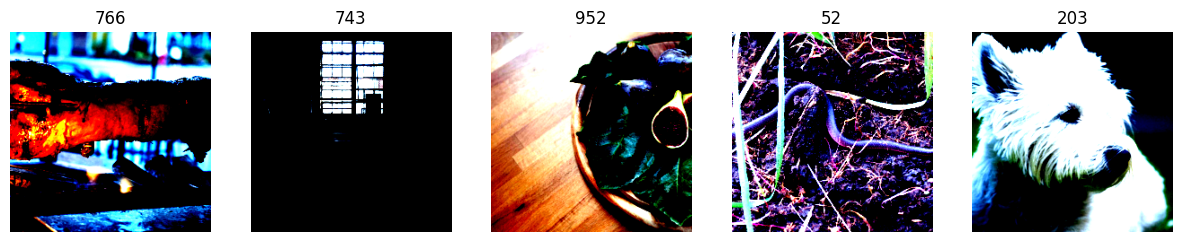

In [ ]:
# itialize the ResNet model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to('cuda')

# initialize the inference transforms
preprocess = weights.transforms()
preprocess

test_loader, data_labels = get_data(32, data_folder, preprocess)

show_images(test_loader)

## MEMO

In [ ]:
from PIL import ImageOps, ImageEnhance

# define some image augmentations

def vertical_flip(img):
    img = TF.to_pil_image(img)
    res = img.transpose(Image.FLIP_TOP_BOTTOM)
    return TF.to_tensor(res)

def brightness(img, factor_range=(0.5, 1.5)):
  img = TF.to_pil_image(img)
  factor = np.random.uniform(factor_range[0], factor_range[1])
  enhancer = ImageEnhance.Brightness(img)
  res = enhancer.enhance(factor)
  return TF.to_tensor(res)

'''
def rotation(img, angle_range=(-45, 45)):
  angle = np.random.uniform(angle_range[0], angle_range[1])
  return img.rotate(angle)
'''

def color(img, factor_range=(0.5, 1.5)):
  img = TF.to_pil_image(img)
  factor = np.random.uniform(factor_range[0], factor_range[1])
  enhancer = ImageEnhance.Color(img)
  res = enhancer.enhance(factor)
  return TF.to_tensor(res)

def sharpness(img, factor_range=(0.5, 1.5)):
  img = TF.to_pil_image(img)
  factor = np.random.uniform(factor_range[0], factor_range[1])
  enhancer = ImageEnhance.Sharpness(img)
  res = enhancer.enhance(factor)
  return TF.to_tensor(res)

augmentations = [vertical_flip, brightness, color, sharpness]

In [ ]:
import random

# functon that apply B augmentations to the original image and return M+1 images
def augment_image(img, augmentations, B=15):
  assert len(augmentations) > 0, "There are not augmentations provided."

  images = [img]
  for _ in range(B):
    # randomly choose an augmentation in the augmentation functions
    index = random.randrange(0, len(augmentations))
    augmentation = augmentations[index]
    # apply the augmentation to the original image
    augmented_img = augmentation(img)
    # add the augmented image to the list of images I want to evaluate
    images.append(augmented_img)
  return images

In [ ]:
# define the cost function used to evaluate the model output
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [ ]:
# define the optimizer
def get_optimizer(net, lr, wd, momentum):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
    return optimizer

In [ ]:
# compute the marginal output distribution
def marginal_distribution(images, model, transforms, device):
  # collect the prediction for every image in input
  img_results = []
  for img in images:
    single_batch = transforms(img).unsqueeze(0).to(device)
    prediction = model(single_batch).squeeze(0).softmax(0)
    img_results.append(prediction)

  # sum all the resulting tensors
  sum_results = torch.sum(torch.stack(img_results), dim=0).to(device)
  # divide each element by B to obtain the marginal output distribution
  num_images = len(images)
  res = torch.div(sum_results, num_images).to(device)
  return res

In [ ]:
# compute the marginal cross entropy
def marginal_cross_entropy(marginal_dist, labels, cost_function):
  entropy = 0.0
  # sum all entropies for the different labels since I don't know the real one
  for label in labels:
    entropy += cost_function(marginal_dist, label)
  return entropy

In [ ]:
import copy

# test time robustness via MEMO algorithm
def ttr_MEMO(model, test_sample, labels, B, cost_function, optimizer, transforms, device):
  # save the original model weights
  original_params = copy.deepcopy(model.state_dict())

  model.train()
  with torch.enable_grad():
    # get the B + 1 images
    augmented_images = augment_image(test_sample, augmentations, B)

    # get the marginal output distribution
    marginal_dist = marginal_distribution(augmented_images, model, transforms, device)

    # update the model weights
    loss = marginal_cross_entropy(marginal_dist, labels, cost_function)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  model.eval()
  with torch.no_grad():
    test_sample = transforms(test_sample).unsqueeze(0).to(device)
    output = model(test_sample).squeeze(0).softmax(0)

  # reapply original weights to the model
  model.load_state_dict(original_params)

  return output

## Test Procedure

In [95]:
def test(model, data_loader, B, cost_function, optimizer, transforms, device="cuda"):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to evaluation mode
  model.eval()

  # disable gradient computation for testing mode
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (inputs, labels) in enumerate(data_loader):
      targets = [data_loader.dataset.classes[label] for label in labels]
      targets = [int(target) for target in targets]
      targets = torch.tensor(targets)
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      batch_size = inputs.size(0)
      num_labels = 1000 # 1000 is the ImageNet number of labels
      empty_tensor = torch.empty(num_labels).to(device)

      # apply MEMO to each test point in the batch
      intermediate_outputs = []
      for input in inputs:
        output = ttr_MEMO(model, input, targets, B, cost_function, optimizer, transforms, device)
        intermediate_outputs.append(output)

      outputs = torch.stack(intermediate_outputs).to(device)

      # outputs_no_MEMO = model(inputs)

      # loss computation
      loss = cost_function(outputs, targets)

      # fetch prediction and loss value
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

## Put all together

In [96]:
from torchvision import transforms

def main(
    run_name,
    batch_size = 32,
    device = "cuda",
    learning_rate=0.001,
    weight_decay=0.000001,
    momentum=0.9,
    num_augmentations = 15
):

  # itialize the ResNet model
  weights = ResNet50_Weights.DEFAULT
  model = resnet50(weights=weights).to(device)

  # initialize the inference transforms
  preprocess = weights.transforms()

  # initialize the test dataloader
  test_loader, _ = get_data(batch_size, data_folder, preprocess)

  show_images(test_loader)

  # initialize the optimizer
  optimizer = get_optimizer(model, learning_rate, weight_decay, momentum)

  # initialize the cost function
  cost_function = get_cost_function()

  test_loss, test_accuracy = test(model, test_loader, num_augmentations, cost_function, optimizer, preprocess, device)
  print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")

The dataset contains 10000 images.
The dataset contains 1000 labels.


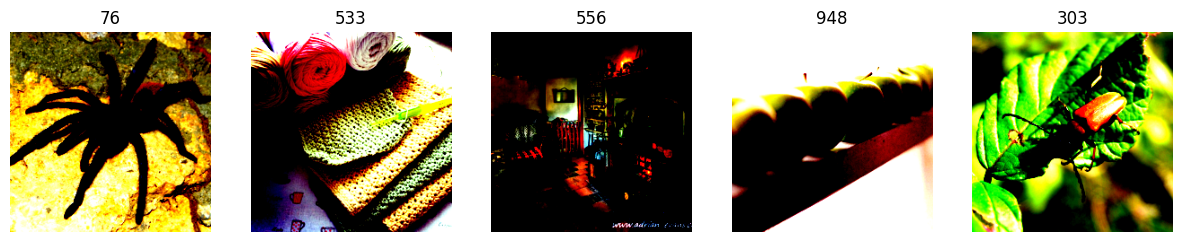

KeyboardInterrupt: 

In [94]:
main("resnet_MEMO")